##**Exercício 1)**

Para uma barra linear estática, podemos definir o problema de mecânica da estruturas conforme o seguinte sistema.

$$\begin{aligned}
\frac{d}{dx}\left(EA \frac{du}{dx} \right) & = -q(x) & \hspace{1.5cm} \text{em} \ \Omega\\
u & = g  &\hspace{1.5cm} \text{em} \ \Gamma_D
\end{aligned}
$$

Em que: q(x) = Cx e, dessa forma, as condições de contorno de Dirichlet são:

$$\begin{aligned}
u(0) = 0 & \hspace{1.5cm} u(L)=\frac{CL^3}{3EA}
\end{aligned}
$$

levando a solução analítica na forma:

$$\begin{aligned}
u(x) = \frac{C}{EA}(\frac{L^2x}{2}-\frac{x^3}{6})
\end{aligned}
$$

Para a implementação numérica considere os seguintes parâmetros:

* EA = 1 (módulo de elasticidade vezes a área da seção);
* O comprimento da barra é L = 5 m;
* A constante C = 10 N/m2

Objetivos do exercício:

**R1)** Os passos para obter a solução analítica do problema;

**R2)** A estrutura da rede utilizada (número de camadas e neurônios);

**R3)** Os parâmetros (quantidade de pontos de colocação, função de ativação).

Teste diferentes cenários referentes aos otimizadores, isto é, resolva para o otimizador Adam com até três
épocas e três taxas de aprendizado, repita o processo para LBFGS. Apresente em uma tabela os resultados
para a Loss Total e o tempo computacional para fazer a otimização e se houve convergência em cada um dos
cenários (total de 18 cenários).

Sugestões de cenários (fique atento a variável print_every)

Learning rate: 0.1, 0.01 e 1E-5 Épocas: 40, 400, 1000

Para um dos cenários anteriores (de preferência que tenha convergido) apresente:

**R4)** Qual o otimizador está sendo usado, o número de épocas e a taxa de aprendizado;

**R5)** Um gráfico comparativo entre a solução da PINN e a solução analítica;

**R6)** Um gráfico dos valores das funções de perda (PDE, BC e Total) pelo número de épocas.

##**Resposta:**

**R2)**

A estrutura da rede neural criada é uma rede neural de alimentação direta (feedforward), também conhecida como Perceptron Multicamadas (MLP).

Entrada (1 neurônio) → Camada Oculta (40 neurônios, Tanh) → Saída (1 neurônio)

**R4)**

* Otimizadores: O código utiliza dois otimizadores diferentes:

Adam (um otimizador de primeira ordem)

LBFGS (um otimizador de segunda ordem)

* Taxas de Aprendizado (learning_rates): O treinamento é executado com três valores distintos para a taxa de aprendizado, que é um hiperparâmetro crucial:

0.1

0.01

1e-5

* Número de Épocas (epochs_list): O número de épocas, que representa quantas vezes o modelo "vê" todos os dados de treinamento, também varia em três cenários:

40

400

1000

**Bibliotecas importantes**

In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager
from matplotlib import rc
import time
import numpy as np
from torch.optim.lbfgs import LBFGS
dtype = torch.float
device = torch.device("cpu")

**R3) Parâmetros do problema**

In [2]:
EA_val = 1.0
L_val = 5.0
C_val = 10.0
dist_load_func = lambda x: C_val * x
u0_boundary = [0, (C_val * L_val**3) / (3 * EA_val)]

**R1) Solução analítica do problema**

Substituindo q(x)=Cx, temos:

$$\begin{aligned}
\frac{d}{dx}\left(EA \frac{du}{dx} \right) & = -Cx
\end{aligned}
$$

Integrando uma vez em relação a x:

$$\begin{aligned}
EA \frac{du}{dx} & = -\int Cx \,dx & = -\frac{Cx^2}{2} - C_1
\end{aligned}
$$

Integrando uma segunda vez em relação a x:

$$\begin{aligned}
u(x) = \frac{1}{EA} \int \left(\frac{-Cx^2}{2} - C_1 \right) \,dx = \frac {1}{EA} \left( \frac{-Cx^3}{6} - C_1x + C_2\right)
\end{aligned}
$$

Agora, aplicamos as condições de contorno para encontrar as constantes de integração C_1 e C_2:

1.   Condição de contorno em x=0: u(0)=0

$$\begin{aligned}
u(0) = \frac {1}{EA} \left( \frac{-C \left( 0 \right) ^3}{6} - C_1 \left( 0 \right) + C_2\right) = 0 ⇒ C_2 = 0
\end{aligned}
$$

2.   Condição de contorno em x=L: u(L)= CL^3/3EA

$$\begin{aligned}
u(L) = \frac {1}{EA} \left( \frac{-CL^3}{6} - C_1L + C_2\right) = \frac{CL^3}{3EA}
\end{aligned}
$$

Como C_2 = 0:

$$\begin{aligned}
u(L) = \frac {1}{EA} \left( \frac{-CL^3}{6} - C_1L \right) = \frac{CL^3}{3EA}
\end{aligned}
$$

Multiplicando ambos os lados por EA:

$$\begin{aligned}
\frac{-CL^3}{6} - C_1L = \frac{CL^3}{3}
\end{aligned}
$$

$$\begin{aligned}
C_1L = \frac{-CL^3}{3} - \frac{CL^3}{6} = \frac{-CL^3}{2}
\end{aligned}
$$

$$\begin{aligned}
C_1 = \frac{-CL^2}{2}
\end{aligned}
$$

Substituindo C_1 e C_2 na solução geral, chegamos à solução analítica correta:

$$\begin{aligned}
u(x) = \frac {1}{EA} \left( \frac{-Cx^3}{6} + \frac{CL^2}{2}x \right)
\end{aligned}
$$

$$\begin{aligned}
u(x) = \frac {C}{EA} \left(\frac{L^2x}{2} - \frac{x^3}{6}\right)
\end{aligned}
$$


In [3]:
def solucao_analitica_exercicio1(x):
    """
    Calcula a solução analítica para o deslocamento u(x) da barra conforme o Exercício 1.
    Parâmetros:
        x (torch.Tensor ou np.ndarray): Posição(ões) ao longo da barra.
    Retorna:
        torch.Tensor ou np.ndarray: Deslocamento(s) u(x).
    """
    # Garante que x é um tensor PyTorch para operações, se ainda não for
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).float().to(device)

    return (C_val / EA_val) * ((L_val**2 * x)/2 - (x**3)/6)

**Malha de pontos**

Gera uma malha 1D de pontos uniformemente espaçados.

Parâmetros:

* length (float): O comprimento do domínio.
* samples (int): O número de pontos a serem gerados.
* initial_coordinate (float): A coordenada inicial do domínio.
      
Retorna:

* torch.Tensor: Um tensor coluna com os pontos gerados, pronto para uso em PyTorch.

In [4]:
def generate_grid_1d(length, samples=100, initial_coordinate=0.0): # Adicionado 'samples' para flexibilidade
    """Gera uma grade de pontos 1D para o domínio, com requires_grad=True."""
    x = torch.linspace(initial_coordinate, initial_coordinate + length, samples, requires_grad=True, device=device, dtype=dtype)
    return x.view(samples, 1)

In [5]:
def get_derivative(y, x, n):
    """Calcula a n-esima deriva de y = f(x) com respeito a x."""
    if n == 0:
        return y
    else:
        # Usa torch.ones_like(y) para garantir que o tensor de gradientes tem o mesmo formato que y
        dy_dx = grad(y, x, torch.ones(x.size()[0], 1, device=device), create_graph=True, retain_graph=True)[0]
        return get_derivative(dy_dx, x, n - 1)

In [6]:
def build_model(input_dimension, hidden_dimension, output_dimension):
    """Construção da rede neural de dimensões fornecidas."""
    modules = []
    modules.append(torch.nn.Linear(input_dimension, hidden_dimension[0]))
    modules.append(torch.nn.Tanh())
    for i in range(len(hidden_dimension) - 1):
        modules.append(torch.nn.Linear(hidden_dimension[i], hidden_dimension[i+1]))
        modules.append(torch.nn.Tanh())
    modules.append(torch.nn.Linear(hidden_dimension[-1], output_dimension))
    model = torch.nn.Sequential(*modules)
    return model.to(device) # Garante que o modelo está no dispositivo correto

### Classe PhysicsInformedBarModel

Esta classe encapsula a lógica do modelo PINN para a barra unidimensional, incluindo a definição da rede, a função de custo e o processo de treinamento.

In [7]:
class PhysicsInformedBarModel:
    """A class used for the definition of Physics Informed Models for one dimensional bars."""

    def __init__(self, E_val, A_val, L_val, u0_boundary, dist_load_func, num_points_EDP):
        """Construct a PhysicsInformedBar model"""
        self.E_val = E_val  # Módulo de Elasticidade (valor constante)
        self.A_val = A_val  # Área da barra (valor constante)
        self.L = L_val      # Comprimento da barra

        # O exemplo usa self.x para pontos de colocação, gerados com generate_grid_1d(L)
        self.x = generate_grid_1d(self.L, samples=num_points_EDP) # Passa num_points_EDP para a função

        # Condições de contorno (Dirichlet)
        # O exemplo usa 'u0', que é uma lista de valores.
        # Precisamos de um tensor para comparação em costFunction, como em u_pred_BC.
        self.u0 = torch.tensor(u0_boundary, device=device, dtype=dtype)

        self.dist_load = dist_load_func # Carregamento na barra (função)

        # Definindo a estrutura da rede (conforme a sugestão do exercício de 2 camadas com 20 neurônios)
        self.model = build_model(1, [40], 1)

        # Histórico da Funcao de Perda (inicializados como None, como no exemplo)
        self.PDE_loss_history = None
        self.ICBC_loss_history = None
        self.total_loss_history = None

        self.optimizer = None # Otimizador

    def get_displacements(self, x):
        """Get displacements."""
        u = self.model(x)  # predict
        return u

    def costFunction(self, x, u_pred):
        """Compute the cost function."""
        # Differential equation loss: d/dx(EA * du/dx) + q(x) = 0
        # No seu exercício, a EDO é: d/dx(EA du/dx) = -q(x)
        # Então, o resíduo é (EA du/dx)' + q(x)
        # Usando self.E_val e self.A_val diretamente para EA
        EDP_res = get_derivative(self.E_val * self.A_val * get_derivative(u_pred, x, 1), x, 1) + self.dist_load(x)
        EDP_loss = torch.sum(EDP_res ** 2).view(1) # Usando torch.sum como no exemplo

        # Boundary condition loss initialization (como no exemplo)
        ICBC_loss = torch.tensor(0.0, device=device, dtype=dtype).view(1) # Inicializa como tensor para soma e garante shape [1]

        # Sum over dirichlet boundary condition losses
        # u_pred[0] é u(0), self.u0[0] é o valor esperado para u(0)
        ICBC_loss += ((u_pred[0] - self.u0[0]) ** 2).view(1)
        # u_pred[-1] é u(L), self.u0[1] é o valor esperado para u(L)
        ICBC_loss += ((u_pred[-1] - self.u0[1]) ** 2).view(1)

        # Garante que ICBC_loss seja um tensor escalar
        ICBC_loss = ICBC_loss.view(1)

        return EDP_loss, ICBC_loss

    def closure(self):
        """Calculation of training error and gradient"""
        self.optimizer.zero_grad()
        u_pred = self.get_displacements(self.x) # Usa self.x (pontos de colocação)
        loss = self.costFunction(self.x, u_pred)
        loss = loss[0] + loss[1] # Soma as componentes da perda
        loss.backward(retain_graph=True) # retain_graph=True conforme o exemplo
        return loss

    def train(self, epochs, print_every, optimizer_name='Adam', learning_rate=1e-3, **kwargs):
        """Train the model."""
        start_time = time.time() # Início da contagem de tempo

        # Set optimizer
        if optimizer_name=='Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, **kwargs)

        elif optimizer_name=='LBFGS':
            self.optimizer = torch.optim.LBFGS(self.model.parameters(), lr=learning_rate, **kwargs)
        else:
            raise ValueError(f"Otimizador '{optimizer_name}' inválido. Escolha 'Adam' ou 'LBFGS'.")

        # Initialize history arrays (como no exemplo, usando np.zeros)
        self.PDE_loss_history = np.zeros(epochs)
        self.ICBC_loss_history = np.zeros(epochs)
        self.total_loss_history = np.zeros(epochs)

        # Training loop
        for i in range(epochs):
            if optimizer_name == 'Adam':
                self.optimizer.zero_grad()
                u_pred = self.get_displacements(self.x)
                PDE_loss, ICBC_loss = self.costFunction(self.x, u_pred)
                total_loss = PDE_loss + ICBC_loss
                total_loss.backward()
                self.optimizer.step()
            elif optimizer_name == 'LBFGS':
                # LBFGS chama closure internamente, que já faz backward() e calcula a perda
                # Captura a perda do closure (closure retorna o total_loss)
                total_loss = self.optimizer.step(self.closure)
                # Para registrar o histórico, precisamos recalcular as perdas após o step do LBFGS
                # ou capturá-las do closure de alguma forma (aqui, recalc para simplicidade).
                # É importante recalcular usando os parâmetros atualizados pelo LBFGS.
                # Uma abordagem é chamar costFunction novamente.
                u_pred_current = self.get_displacements(self.x)
                PDE_loss, ICBC_loss = self.costFunction(self.x, u_pred_current)
                # total_loss já foi calculado pelo closure e usado para o step,
                # mas para o histórico usamos os valores decompostos.


            # Add energy values to history
            self.PDE_loss_history[i] = PDE_loss.item() # .item() para extrair o valor escalar para numpy
            self.ICBC_loss_history[i] = ICBC_loss.item()
            self.total_loss_history[i] = total_loss.item() # Usa o total_loss calculado (se Adam) ou retornado pelo closure (se LBFGS)


            # Print training state
            self.print_training_state(i, epochs, print_every)

        end_time = time.time() # Fim da contagem de tempo

        final_loss = self.total_loss_history[-1] if len(self.total_loss_history) > 0 else float('inf')
        training_time = end_time - start_time
        converged = final_loss < 1e-4 # Critério de convergência
        return final_loss, training_time, converged


    def print_training_state(self, epoch, epochs, print_every):
        """Print the loss values of the current epoch in a training loop."""
        if epoch == 0 or epoch == (epochs - 1) or epoch % print_every == 0 or print_every == 'all':
            # Prepare string (ajustado para os nomes PDE_loss e ICBC_loss)
            string = "Epoch: {}/{}\t\tPDE loss = {:2e}\t\tICBC loss = {:2e}\t\tTotal loss = {:2e}"

            # Format string and print
            print(string.format(epoch, epochs - 1, self.PDE_loss_history[epoch],
                                 self.ICBC_loss_history[epoch], self.total_loss_history[epoch]))

    def plot_training_history(self, yscale='log'):
        """Plot the training history."""
        # Set up plot
        fig, ax = plt.subplots(figsize=(4,3))
        ax.set_title("Historico da Função de Custo")
        ax.set_xlabel("Epocas")
        ax.set_ylabel("Funcao de Custo")
        plt.yscale(yscale)

        # Plot data
        ax.plot(self.total_loss_history, 'k', linewidth=2, label="Total")
        ax.plot(self.PDE_loss_history, color='silver', linestyle='--', linewidth=2, label="DE loss")
        ax.plot(self.ICBC_loss_history, color='r', linestyle='-.', linewidth=2, label="BC loss")
        ax.legend()
        fig.tight_layout()
        plt.show()

## Funções de Plotagem e Execução Principal

# --- Configurações de Plotagem (conforme o exemplo) ---
matplotlib.rcParams["figure.dpi"] = 150
rc('text', usetex=False)

def plot_displacements_bar(x, u, u_analytic=None):
    """Plot displacements."""

    # Set up plot
    fig, ax = plt.subplots(figsize=(4,3))
    ax.set_title("Deslocamentos")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u(x)$")

    # Plot da Solucao Analitica
    if u_analytic is not None:
        # Garante que a função analítica recebe um numpy array
        x_np = x.detach().cpu().numpy()
        ax.plot(x_np, u_analytic(x_np).cpu().numpy(), color='r', linewidth=2, label="$u_{true}$")

    # Plot da Solucao da PINN
    ax.plot(x.detach().cpu().numpy(), u.detach().cpu().numpy(), color='k', linestyle=':', linewidth=5, label="$u_{pred}$")

    ax.legend()
    plt.show()
    fig.tight_layout()

# --- Execução Principal do Exercício 1 ---

# Gerando o modelo com os parâmetros do Exercício 1
# O número de pontos de colocação (num_points_EDP) é hardcodado para 100 no Exercício 1.
num_points_EDP = 100
pinnModel = PhysicsInformedBarModel(E_val=EA_val, A_val=EA_val, L_val=L_val,
                                    u0_boundary=u0_boundary, dist_load_func=dist_load_func,
                                    num_points_EDP=num_points_EDP)

results = []
learning_rates = [0.1, 0.01, 1e-5]
epochs_list = [40, 400, 1000]

print("Iniciando cenários com otimizador Adam...")
for lr in learning_rates:
    for epochs in epochs_list:
        # Re-instancia o modelo para cada cenário para garantir um "novo começo"
        current_pinn_model = PhysicsInformedBarModel(E_val=EA_val, A_val=EA_val, L_val=L_val,
                                                    u0_boundary=u0_boundary, dist_load_func=dist_load_func,
                                                    num_points_EDP=num_points_EDP)
        print_every_val = max(1, epochs // 10) # Garante que print_every seja pelo menos 1

        final_loss, training_time, converged = current_pinn_model.train(epochs, print_every_val,
                                                                         optimizer_name='Adam', learning_rate=lr)
        results.append(('Adam', lr, epochs, final_loss, training_time, converged))
        print(f"Adam - LR: {lr}, Épocas: {epochs}, Loss: {final_loss:.2e}, Tempo: {training_time:.2f}s, Convergência: {converged}")

print("\nIniciando cenários com otimizador LBFGS...")
for lr in learning_rates:
    for epochs in epochs_list:
        # Re-instancia o modelo para cada cenário
        current_pinn_model = PhysicsInformedBarModel(E_val=EA_val, A_val=EA_val, L_val=L_val,
                                                    u0_boundary=u0_boundary, dist_load_func=dist_load_func,
                                                    num_points_EDP=num_points_EDP)
        print_every_val = max(1, epochs // 10)

        # Parâmetros adicionais para LBFGS conforme o exemplo
        final_loss, training_time, converged = current_pinn_model.train(epochs, print_every_val,
                                                                         optimizer_name='LBFGS', learning_rate=lr,
                                                                         max_iter=20, history_size=100)
        results.append(('LBFGS', lr, epochs, final_loss, training_time, converged))
        print(f"LBFGS - LR: {lr}, Épocas: {epochs}, Loss: {final_loss:.2e}, Tempo: {training_time:.2f}s, Convergência: {converged}")

# --- Tabela de Resultados ---
print("\n--- Tabela de Resultados ---")
print("| Otimizador | Learning Rate | Épocas | Loss Total (Final) | Tempo (s) | Convergência |")
print("|:----------:|:-------------:|:------:|:------------------:|:---------:|:------------:|")
for res in results:
    opt, lr, ep, loss, t_time, conv = res
    print(f"| {opt} | {lr} | {ep} | {loss:.2e} | {t_time:.2f} | {'Sim' if conv else 'Não'} |")

# --- Análise Detalhada de um Cenário Convergente ---
print("\n--- Análise Detalhada de um Cenário Convergente ---")
# Re-executar um cenário que convergiu para plotagem
# Exemplo de um bom cenário. Você pode ajustar este após a primeira execução completa
# para um cenário que demonstre boa convergência.
best_scenario_opt = 'LBFGS' # Geralmente LBFGS converge mais rápido em PINNs simples
best_scenario_lr = 0.1 # Teste com 0.1 ou 0.01
best_scenario_epochs = 400 # Um número razoável para LBFGS

print(f"\nRe-executando o cenário para plotagem: Otimizador={best_scenario_opt}, LR={best_scenario_lr}, Épocas={best_scenario_epochs}")

# Cria uma nova instância do modelo para o cenário de plotagem
pinn_model_plot = PhysicsInformedBarModel(E_val=EA_val, A_val=EA_val, L_val=L_val,
                                         u0_boundary=u0_boundary, dist_load_func=dist_load_func,
                                         num_points_EDP=num_points_EDP)

print_every_plot = max(1, best_scenario_epochs // 10) # Frequência de print para o cenário de plotagem

# Treina o modelo para o cenário escolhido
if best_scenario_opt == 'LBFGS':
    pinn_model_plot.train(best_scenario_epochs, print_every_plot,
                          optimizer_name=best_scenario_opt, learning_rate=best_scenario_lr,
                          max_iter=20, history_size=100)
else: # Adam
    pinn_model_plot.train(best_scenario_epochs, print_every_plot,
                          optimizer_name=best_scenario_opt, learning_rate=best_scenario_lr)

    # Test data para plotagem
samples_plot = 100
x_plot = generate_grid_1d(L_val, samples=samples_plot)
u_pinn_plot = pinn_model_plot.get_displacements(x_plot)

# Solução Analítica (passa a função diretamente)
u_analytic_plot = solucao_analitica_exercicio1

Iniciando cenários com otimizador Adam...
Epoch: 0/39		PDE loss = 8.414080e+04		ICBC loss = 1.740980e+05		Total loss = 2.582388e+05
Epoch: 4/39		PDE loss = 7.911888e+04		ICBC loss = 1.610700e+05		Total loss = 2.401889e+05
Epoch: 8/39		PDE loss = 7.219970e+04		ICBC loss = 1.482512e+05		Total loss = 2.204509e+05
Epoch: 12/39		PDE loss = 6.332478e+04		ICBC loss = 1.364238e+05		Total loss = 1.997486e+05
Epoch: 16/39		PDE loss = 5.432570e+04		ICBC loss = 1.257876e+05		Total loss = 1.801133e+05
Epoch: 20/39		PDE loss = 4.652731e+04		ICBC loss = 1.157874e+05		Total loss = 1.623147e+05
Epoch: 24/39		PDE loss = 3.978897e+04		ICBC loss = 1.063091e+05		Total loss = 1.460981e+05
Epoch: 28/39		PDE loss = 3.372672e+04		ICBC loss = 9.804906e+04		Total loss = 1.317758e+05
Epoch: 32/39		PDE loss = 2.853828e+04		ICBC loss = 9.044099e+04		Total loss = 1.189793e+05
Epoch: 36/39		PDE loss = 2.379627e+04		ICBC loss = 8.396409e+04		Total loss = 1.077604e+05
Epoch: 39/39		PDE loss = 2.094611e+04		ICBC loss = 

**R5) Gráfico comparativo entre a solução da PINN e a solução analítica**

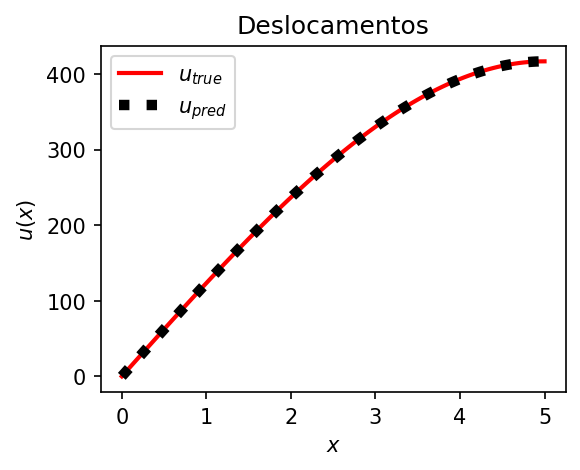

In [10]:
# Plotar resultados (comparativo)
plot_displacements_bar(x_plot, u_pinn_plot, u_analytic=u_analytic_plot)

**R6) Gráfico dos valores das funções de perda (PDE, BC e Total) pelo número de épocas**

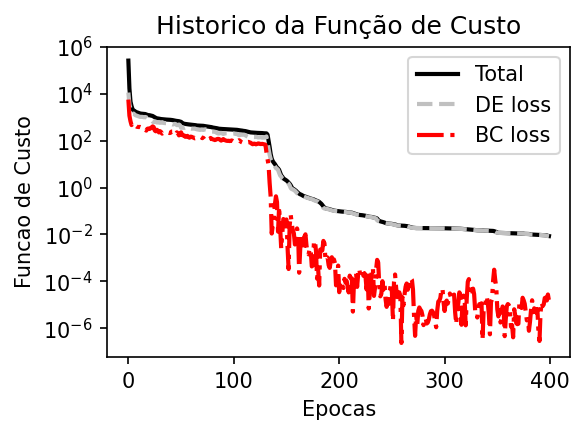

In [11]:
# Plotar histórico de treinamento
pinn_model_plot.plot_training_history()